# REDUCED SET

In [1]:
from template_csp import managetemp as mte
from template_csp.managetemp import levensthein_distance
import numpy as np
import pandas as pd
import random
hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1,
    "lev_red" : 0.9
}
comp = 1
df = pd.read_csv(f'A{comp}B/relaxation/RELAX_DATA', sep=",", index_col=0, na_filter = False)
test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

template_set = mte.TemplateSet(test_elements, 'RANDOM/FULL5sets/77/TemplateSet_1')
pairset = mte.PairSet(template_set, test_elements, 'RANDOM/FULL5sets/77/PairSet_1')
reducted_set = pairset.reduced_set(hyperparameters)
subset_templates = [f'{template_set.couples[i][0][0]}{template_set.couples[i][0][1]}_{template_set.couples[i][1]}' for i in reducted_set]
n_temp_test = len(subset_templates)

pmatrix = {}
couples = np.array([])

for i in range(len(test_elements)):
    for j in range(i+1,len(test_elements)):
        couple = [test_elements[i],test_elements[j]]
        couple.sort()
        couple = ''.join(couple)
        pvec = np.zeros((2, len(subset_templates)))

        for idx, template in enumerate(subset_templates):
            pvec[0,idx] = df.loc[couple,template]
            pvec[1,idx] = idx
        
        sorted_idx = np.argsort(pvec[0])
        pvec[0] = pvec[0][sorted_idx]
        pvec[1] = pvec[1][sorted_idx]

        pmatrix[couple] = pvec
        couples = np.append(couples, couple)

lev_dist_matrix = np.zeros((len(couples), len(couples)))

for row, couple1 in enumerate(couples):
    for col, couple2 in enumerate(couples):
        if row == col:
            lev_dist_matrix[row,col] = 0
        else:
            lev_dist_matrix[row,col] = levensthein_distance(pmatrix[couple1][1], pmatrix[couple2][1]) 
print(len(subset_templates))

13


# DENDOGRAM

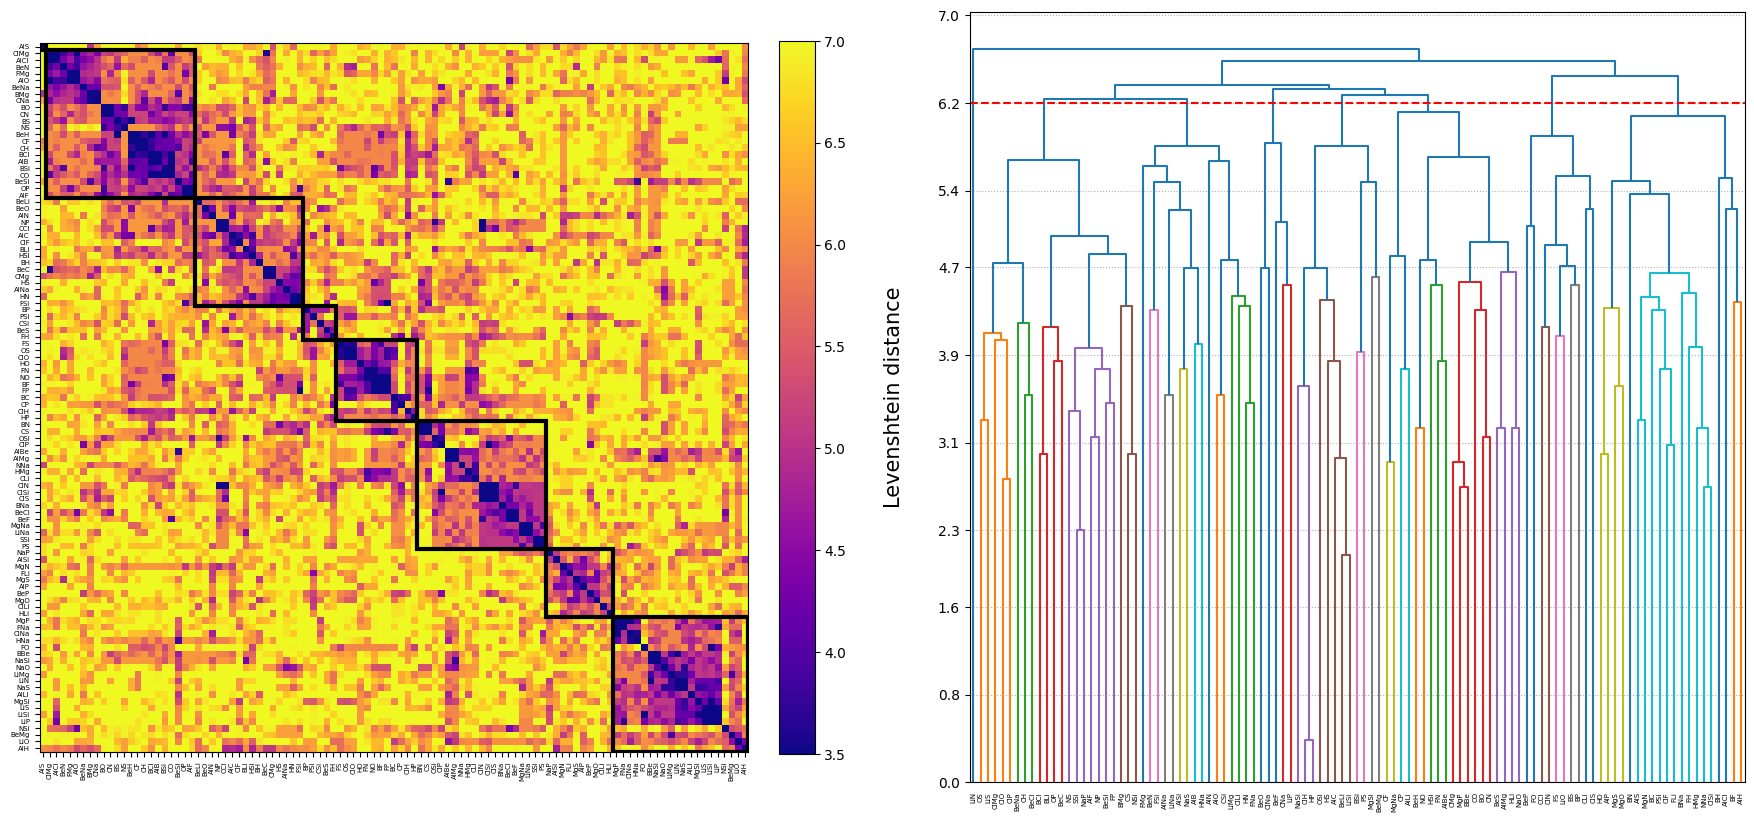

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.patches as patches

condensed_dist_matrix = squareform(lev_dist_matrix)
Z = linkage(condensed_dist_matrix, method='average')
dendro = dendrogram(Z, no_plot=True)
sorted_idx = dendro['leaves']
threshold = 3
desired_clusters = 8
num_clusters = np.inf
while num_clusters > desired_clusters:
    threshold += 0.1
    cluster_labels = fcluster(Z, t=threshold, criterion="distance")
    num_clusters = len(np.unique(cluster_labels)) 


new = lev_dist_matrix[sorted_idx, :][:, sorted_idx]
cluster_labels_sorted = cluster_labels[sorted_idx]

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw={"width_ratios": [3, 3]})
im = ax.imshow(new, cmap='plasma') #or Spectral
im.set_clim((n_temp_test+1)/4, (n_temp_test+1)/2)

couples_in_clusters = []

unique_clusters = np.unique(cluster_labels_sorted)
for cluster in unique_clusters:
    # Trova gli indici che appartengono a questo cluster
    cluster_indices = np.where(cluster_labels_sorted == cluster)[0]
    if len(cluster_indices) > 0:
        # Trova il primo e l'ultimo elemento del cluster per i bordi
        start, end = cluster_indices[0], cluster_indices[-1]
        cluster_size = end - start + 1
        couples_in_clusters.append(np.array(couples)[sorted_idx][start:end+1])

        # Aggiungi un rettangolo per evidenziare il cluster con un piccolo offset
        rect = patches.Rectangle((start - 0.5, start - 0.5), cluster_size, cluster_size,
                                 linewidth=3, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

# Imposta i tick e mostra la figura
ax.set_xticks(np.arange(len(couples)))
ax.set_yticks(np.arange(len(couples)))
ax.set_xticklabels(np.array(couples)[sorted_idx], fontsize=5, rotation=90)
ax.set_yticklabels(np.array(couples)[sorted_idx], fontsize=5)
fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)


dendrogram(Z, labels=np.array(couples)[sorted_idx], leaf_rotation=90, leaf_font_size=5, ax=ax1)
ax1.axhline(y=threshold, color='r', linestyle='--')
ax1.set_ylabel('Levenshtein distance', fontsize=15)
ax1.yaxis.set_label_coords(-0.085, 0.5)
yticks = np.linspace(0, (n_temp_test+1)/2, 10)
yticks = np.round(yticks, decimals=1)
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=10)
ax1.grid(True, ls=':', axis='y')
plt.show()


In [ ]:
import re

new_clusters = [np.array([])]
freq = [0]
for i in couples_in_clusters:
    if len(i) == 1:
        new_clusters[0] = np.append(new_clusters[0],i[0])
        freq[0]+=1./105
    else:
        new_clusters.append(i)
        freq.append(float(len(i))/105)
freq = np.array(freq)
sorted_idx = np.argsort(freq)
freq = freq[sorted_idx]
new_clusters = [new_clusters[i].tolist() for i in sorted_idx]
for idx, cluster in enumerate(new_clusters):
    new_clusters[idx] = [re.findall(r'[A-Z][^A-Z]*', j) for j in cluster]

clusters = {}
for i in range(len(freq)):
    clusters[f'{i}'] = {
        'couples' : new_clusters[i],
        'freq' : freq[i]
    }
import json
with open('clusters.json', 'w') as f:
    json.dump(clusters, f, indent=4)

# PIE CHART

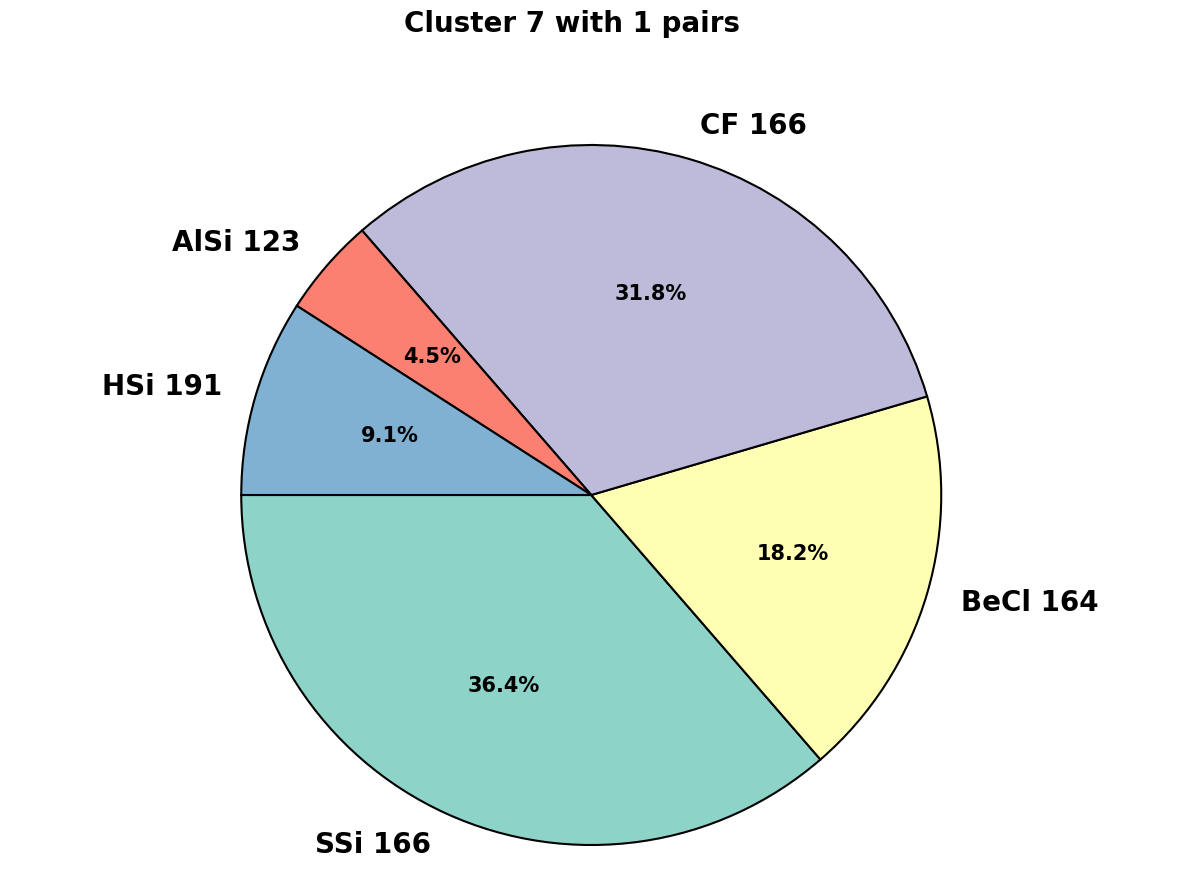

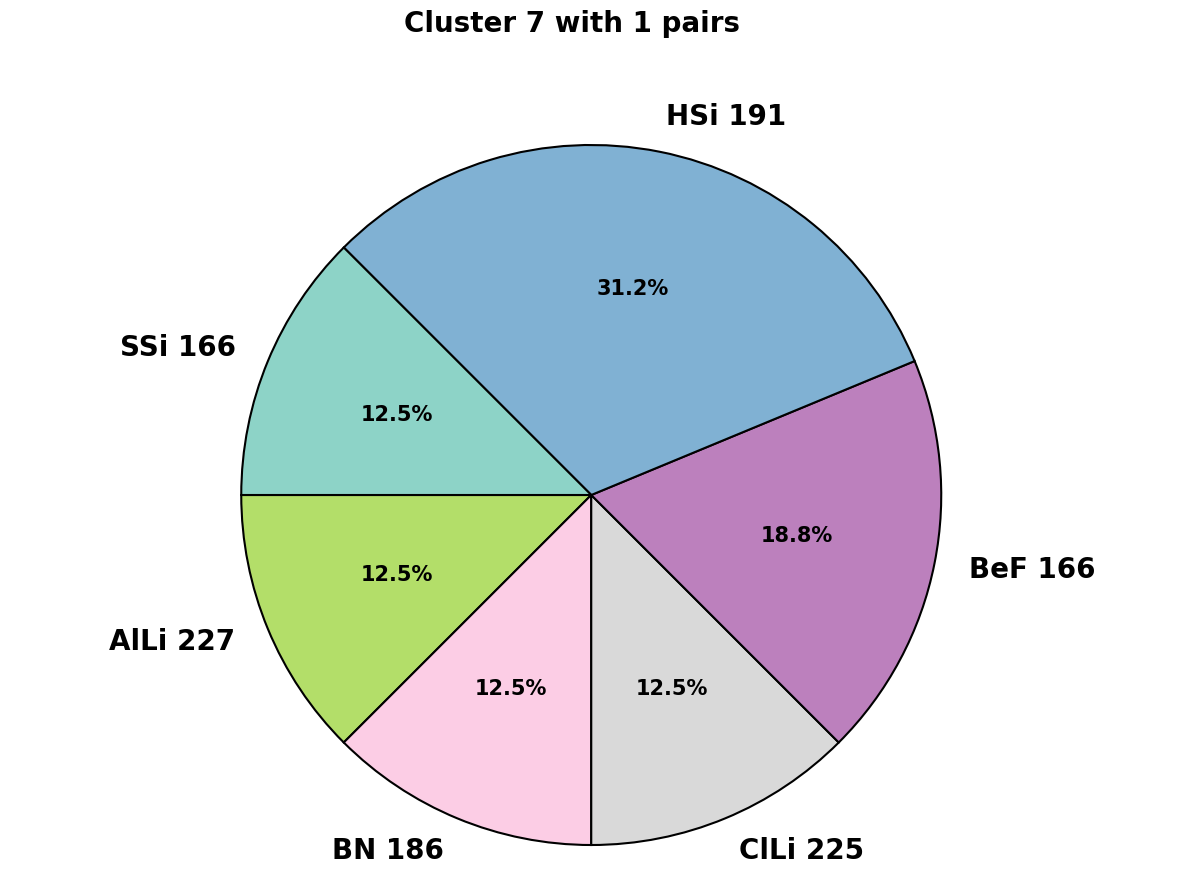

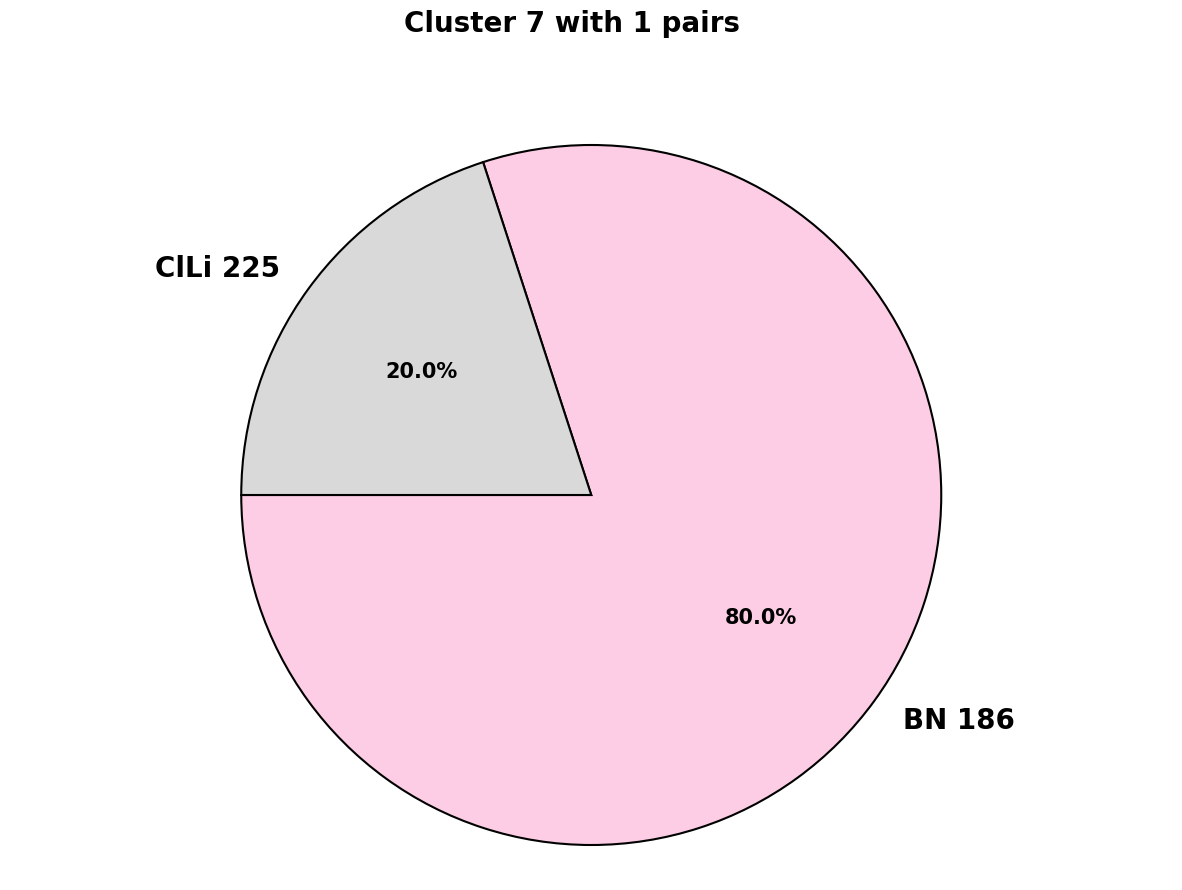

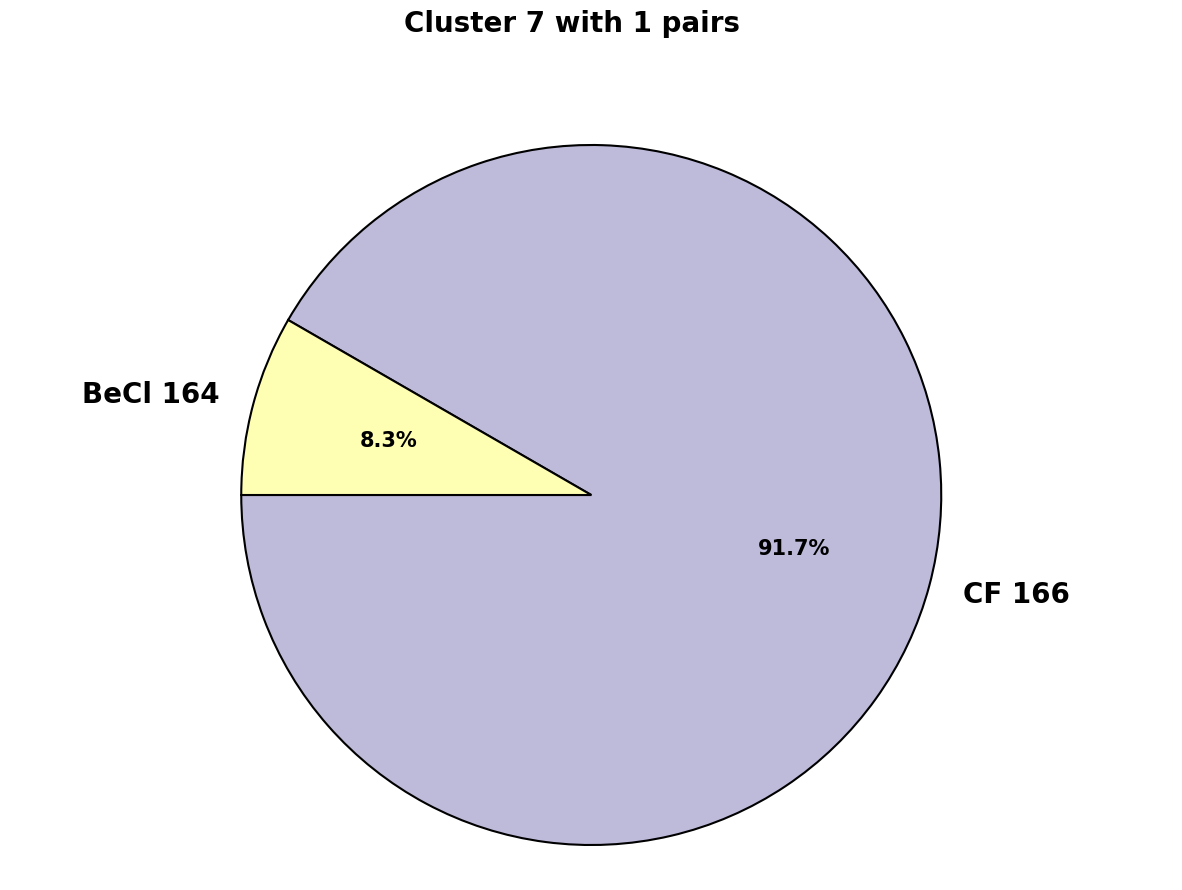

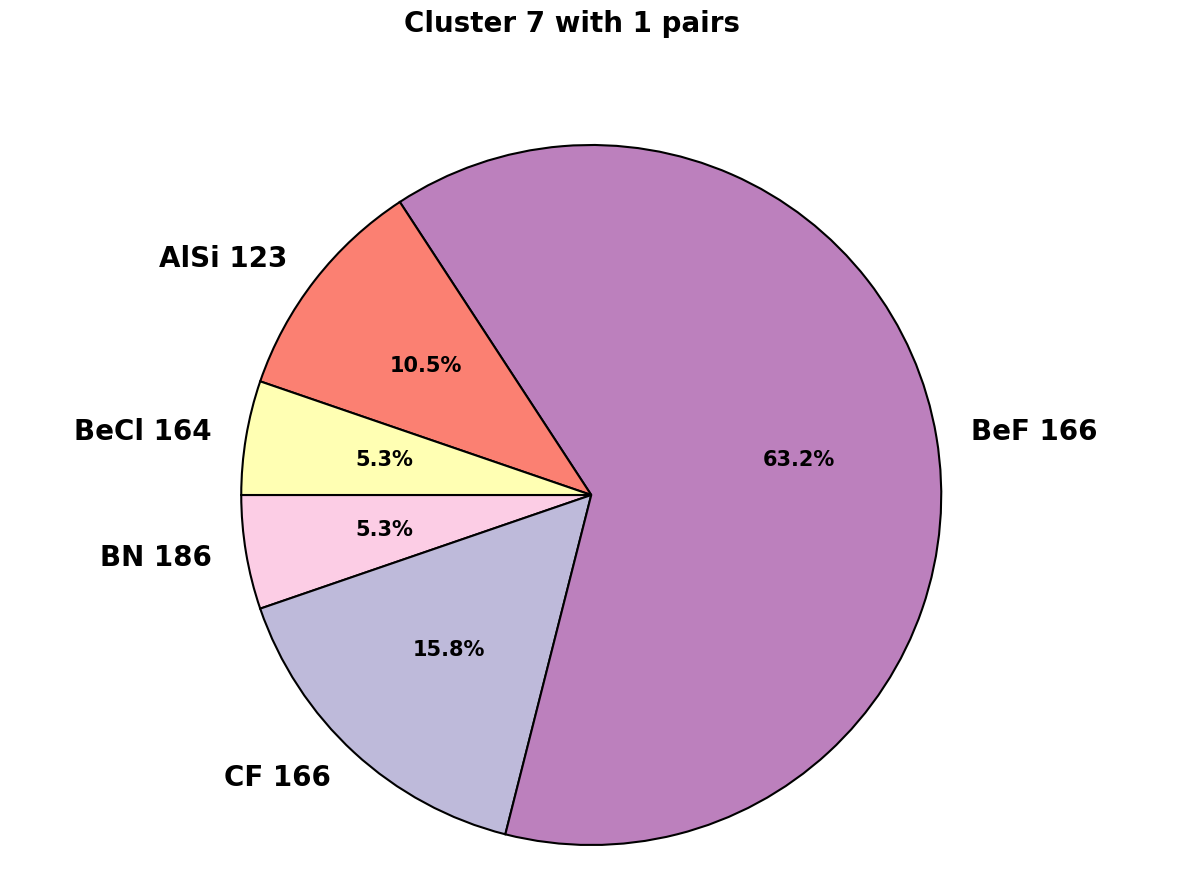

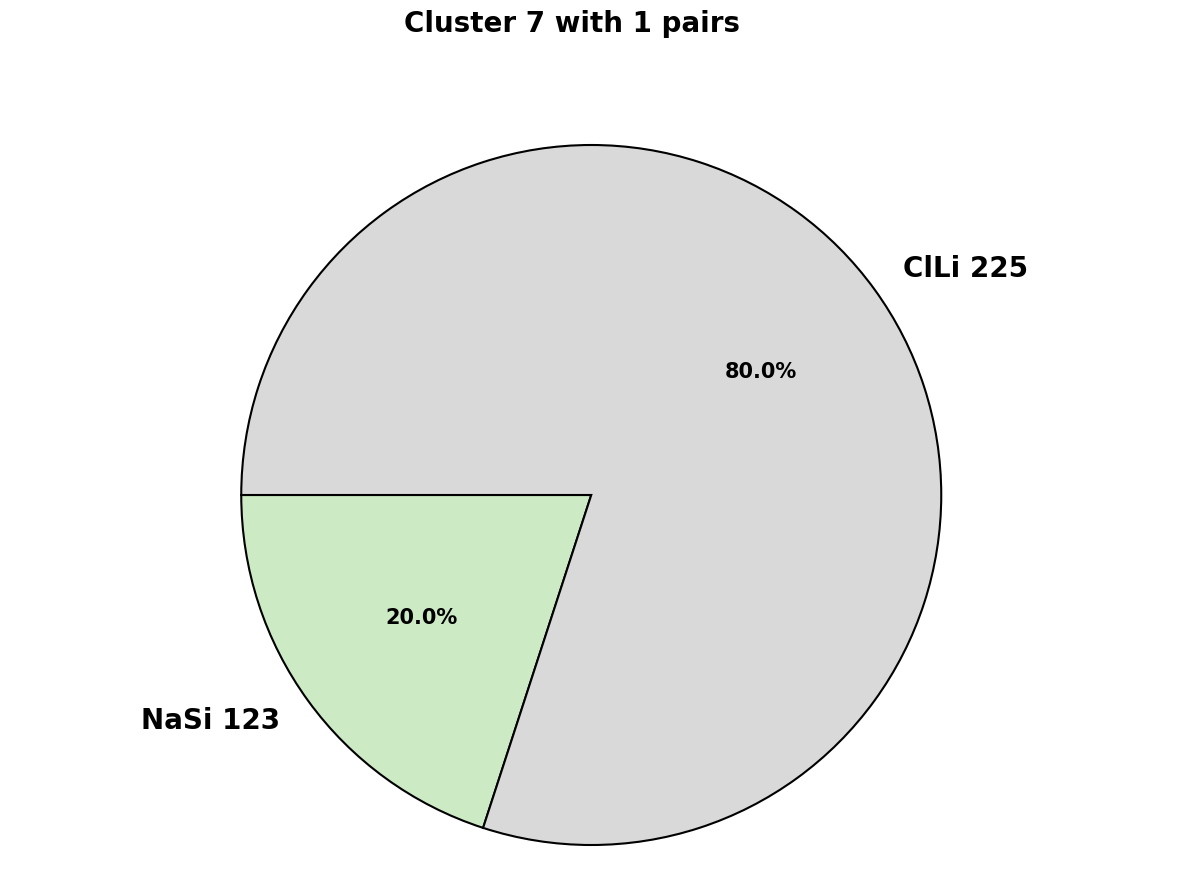

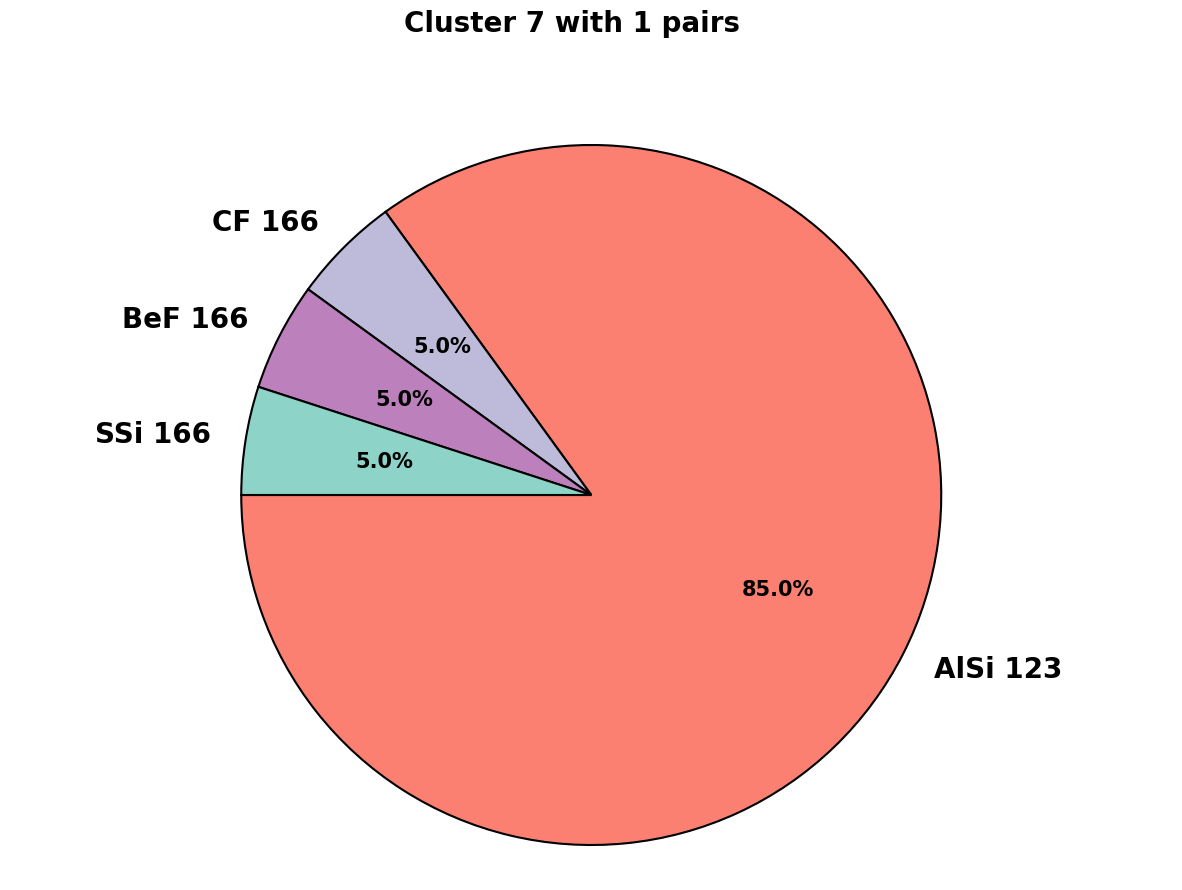

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
total_hist = {}
hist = {}
for idx_cluster, cluster in enumerate(couples_in_clusters):
    if len(cluster) == 1:
        continue

    hist[f'{idx_cluster}'] = {}
    
    for i in cluster:
        for j in range(1):
            if int(pmatrix[i][1][j]) not in hist[f'{idx_cluster}'].keys():
                hist[f'{idx_cluster}'][int(pmatrix[i][1][j])] = 1/len(cluster)
            else:
                hist[f'{idx_cluster}'][int(pmatrix[i][1][j])] +=1/len(cluster)
                
            if int(pmatrix[i][1][j]) not in total_hist.keys():
                total_hist[int(pmatrix[i][1][j])] = 1/len(cluster)
            else:
                total_hist[int(pmatrix[i][1][j])] +=1/len(cluster)
#TEN TOTAL TEMPLATES AS GROUND STATE

colormap = {}
for idx, template in enumerate(total_hist.keys()):
    colormap[f'{template}'] = cm.Set3(idx/len(total_hist.keys()))

for idx, histcluster in enumerate(hist.values()):
    fig, ax = plt.subplots(1,1,figsize=(15, 10))
    fig.suptitle(f'Cluster {idx_cluster}', fontsize=20, fontweight='bold')
    labels = [f'{i.split('_')[0]} {i.split('_')[1]}' for i in np.array(subset_templates)[list(histcluster.keys())]]
    colors = [colormap[f'{int(i)}'] for i in histcluster.keys()]
    wedges, texts, autotexts = ax.pie(histcluster.values(), autopct='%1.1f%%' ,labels = labels, colors = colors,wedgeprops=dict(edgecolor='black', linewidth=1.5), startangle=180)
    ax.axis('equal')
    # Personalizzazione del testo
    for text in texts:
        text.set_fontsize(20)  # Dimensione dei label
        text.set_color('black')
        text.set_fontweight('bold')  # Colore dei label

    for autotext in autotexts:
        autotext.set_fontsize(15)  # Dimensione delle percentuali
        autotext.set_color('black')  # Colore delle percentuali
        autotext.set_weight('bold')  # Grassetto per le percentuali
    plt.show()
            


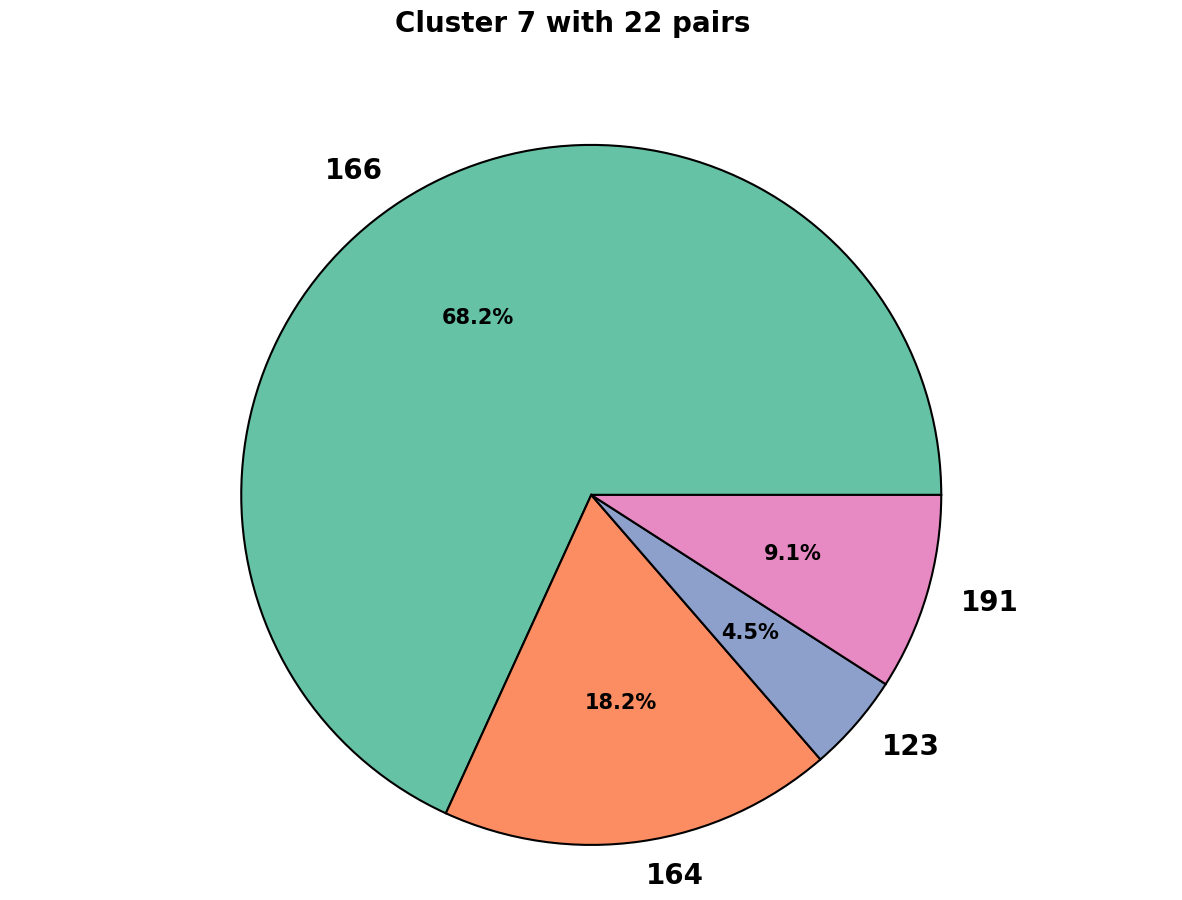

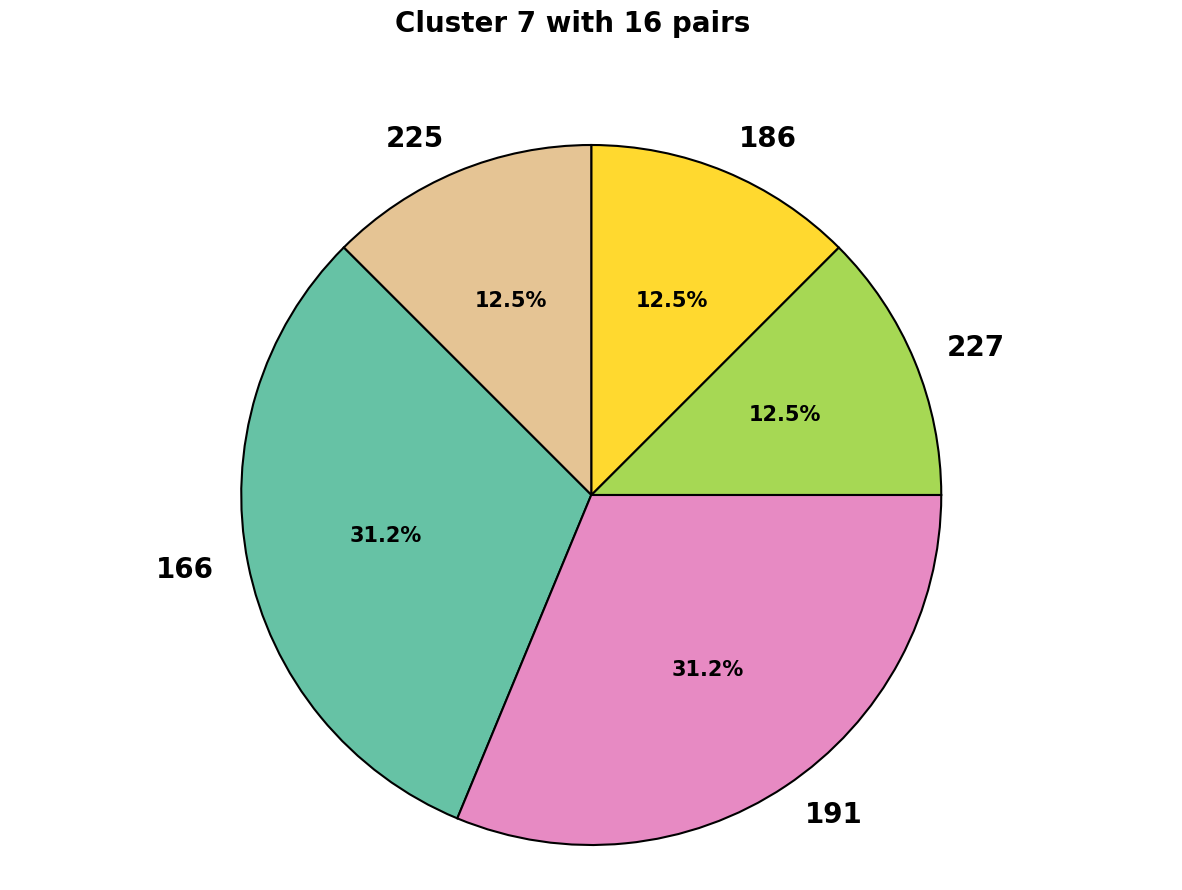

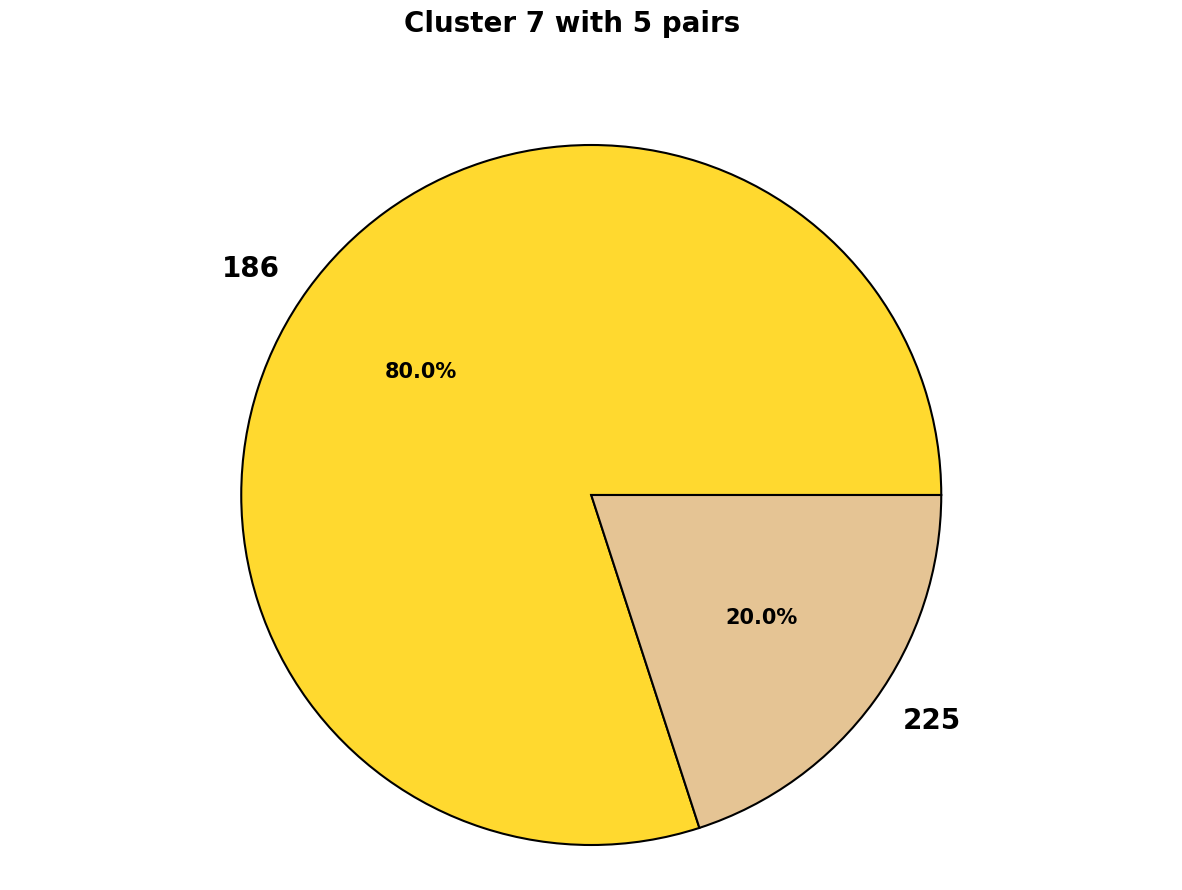

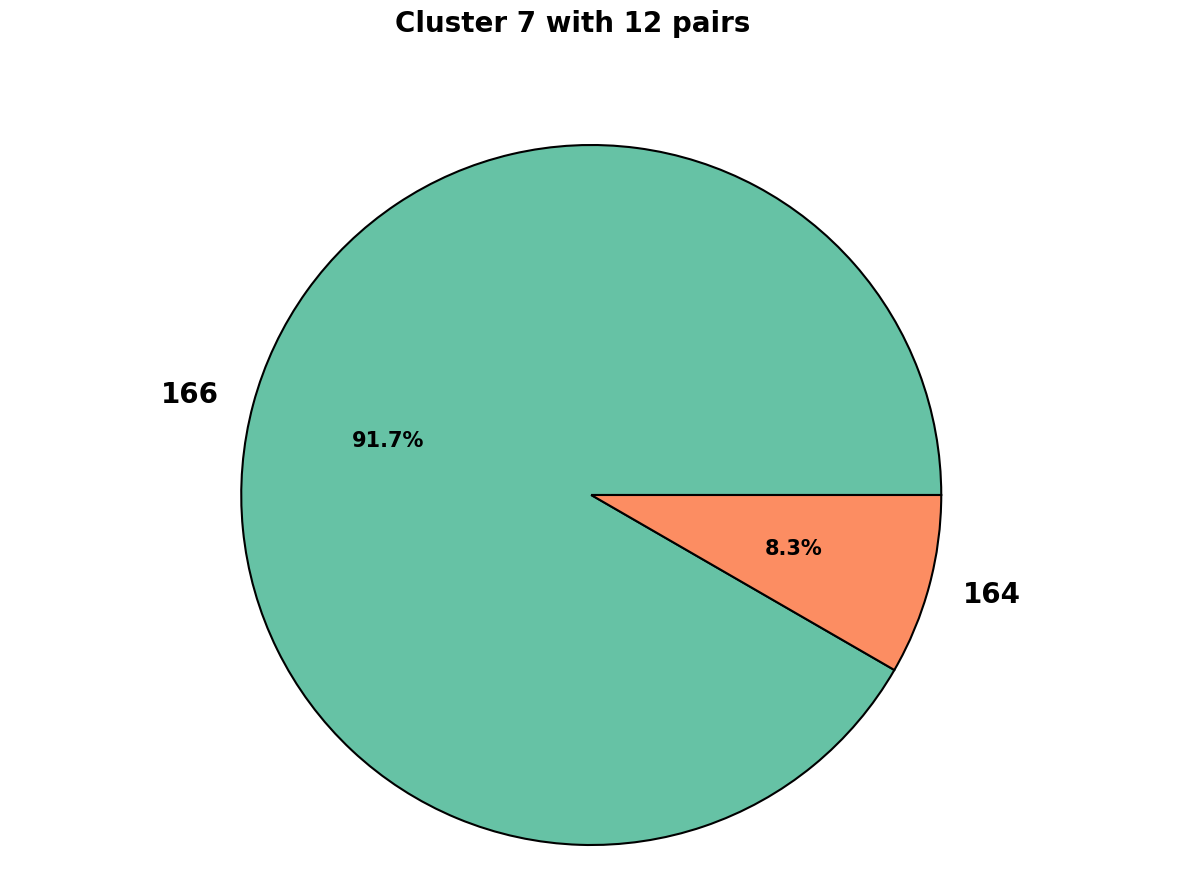

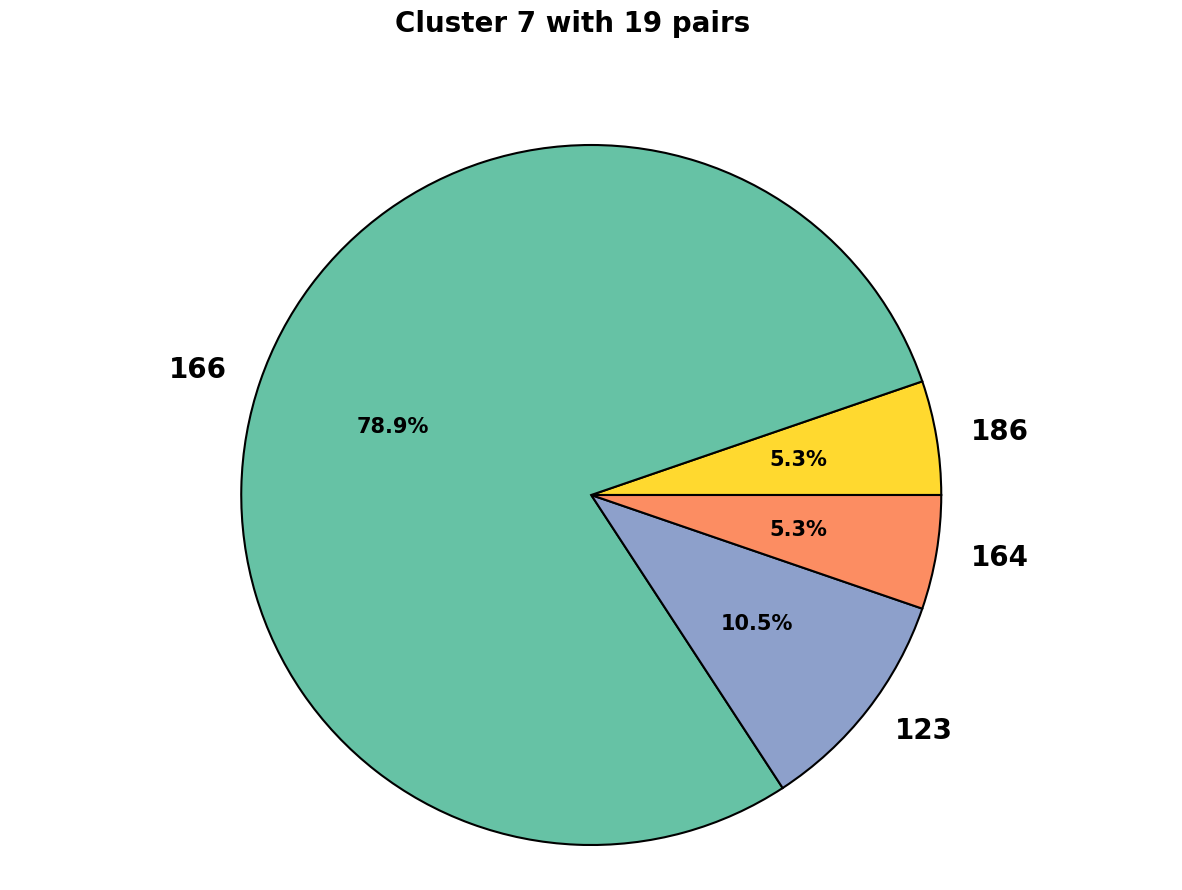

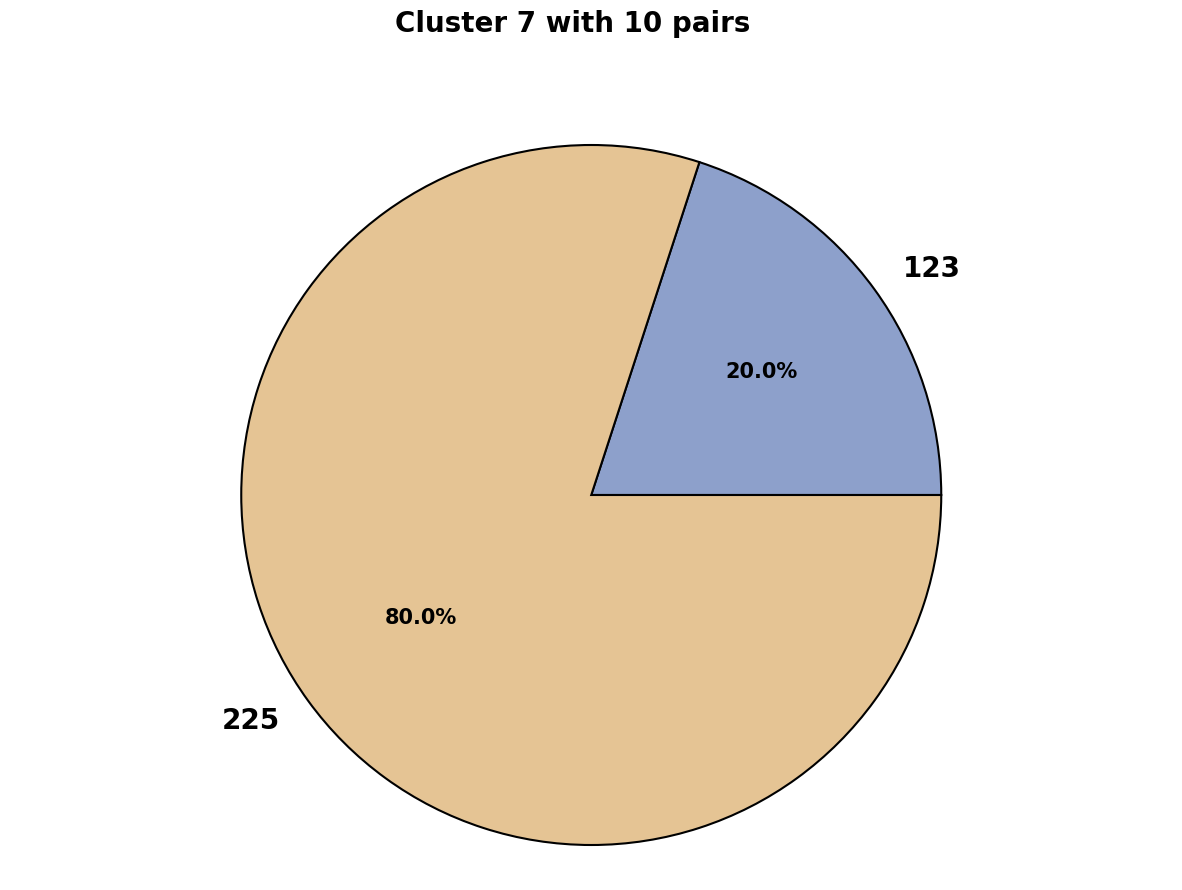

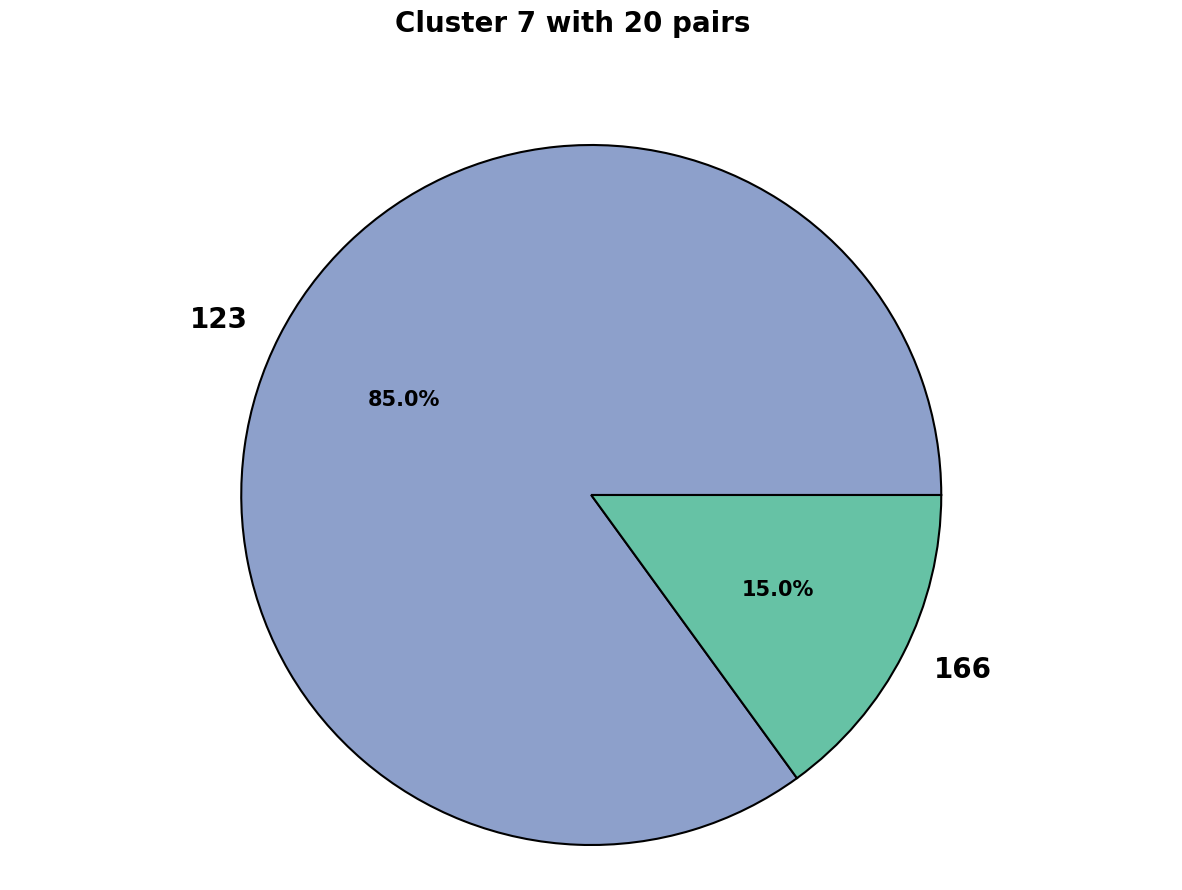

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
total_hist = {}
hist = {}
len_cluster = []
for idx_cluster, cluster in enumerate(couples_in_clusters):
    if len(cluster) == 1:
        continue
    hist[f'{idx_cluster}'] = {}
    len_cluster.append(len(cluster))
    for i in cluster:
        for j in range(1):
            sg = subset_templates[int(pmatrix[i][1][j])].split('_')[1]

            if sg not in hist[f'{idx_cluster}'].keys():
                hist[f'{idx_cluster}'][sg] = 1/len(cluster)
            else:
                hist[f'{idx_cluster}'][sg] +=1/len(cluster)
                
            if sg not in total_hist.keys():
                total_hist[sg] = 1/len(cluster)
            else:
                total_hist[sg] +=1/len(cluster)
colormap = {}
for idx, template in enumerate(total_hist.keys()):
    colormap[f'{template}'] = cm.Set2(idx/len(total_hist.keys()))

for idx, histcluster in enumerate(hist.values()):
    fig, ax = plt.subplots(1,1,figsize=(15, 10))
    fig.suptitle(f'Cluster {idx_cluster} with {len_cluster[idx]} pairs', fontsize=20, fontweight='bold')
    colors = [colormap[f'{int(i)}'] for i in histcluster.keys()]
    wedges, texts, autotexts = ax.pie(histcluster.values(), autopct='%1.1f%%' ,labels = histcluster.keys(), colors = colors, wedgeprops=dict(edgecolor='black', linewidth=1.5), startangle=0)
    ax.axis('equal')
    # Personalizzazione del testo
    for text in texts:
        text.set_fontsize(20)  # Dimensione dei label
        text.set_color('black')
        text.set_fontweight('bold')  # Colore dei label

    for autotext in autotexts:
        autotext.set_fontsize(15)  # Dimensione delle percentuali
        autotext.set_color('black')  # Colore delle percentuali
        autotext.set_weight('bold')  # Grassetto per le percentuali
    plt.show()
            
